In [1]:
!which python

/mnt/home/moham147/experiments/manifold-learning/.venv/bin/python


# Generate data

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import csv

# Create output directory
IMG_DIR = "data/clock_images"
os.makedirs(IMG_DIR, exist_ok=True)

# Define the fixed output size
IMG_SIZE = 64

LABELS_FILE = "data/clock_labels.csv"

def draw_clock(hour, minute, save_path, img_size=IMG_SIZE):
    """Generates a clock image at a given hour/minute and resizes it."""
    fig, ax = plt.subplots(figsize=(2,2), dpi=100)  # Higher DPI for better quality

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

    # Draw clock face
    circle = plt.Circle((0, 0), 1, edgecolor="black", facecolor="white", lw=3)
    ax.add_patch(circle)

    # Compute hand angles
    hour_angle = np.pi / 2 - (2 * np.pi * (hour % 12) / 12) - (2 * np.pi * (minute / 60) / 12)
    minute_angle = np.pi / 2 - (2 * np.pi * minute / 60)

    # Draw hands
    ax.plot([0, 0.5 * np.cos(hour_angle)], [0, 0.5 * np.sin(hour_angle)], 'k', lw=5)  # Hour hand
    ax.plot([0, 0.8 * np.cos(minute_angle)], [0, 0.8 * np.sin(minute_angle)], 'k', lw=3)  # Minute hand

    # Save image with padding
    plt.axis('off')
    temp_path = "data/temp.png"
    plt.savefig(temp_path, bbox_inches='tight', pad_inches=0.1)  # Small padding
    plt.close()

    # Load image and resize
    img = Image.open(temp_path).convert("L")  # Convert to grayscale
    img = img.resize((img_size, img_size), Image.LANCZOS)  # Resize to power of 2
    img.save(save_path)

# Open CSV file for writing labels
with open(LABELS_FILE, mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["filename", "hour", "minute", "time_in_minutes"])

    # Generate clock images at different times
    for hour in range(12):  # 12-hour format
        for minute in range(0, 60, 1):  # Every 5 minutes
            filename = f"clock_{hour:02d}_{minute:02d}.png"
            save_path = os.path.join(IMG_DIR, filename)
            draw_clock(hour, minute, save_path)

            # Compute single number label (time in minutes past midnight)
            time_in_minutes = hour * 60 + minute

            # normalize minute, hour, and total minutes
            hour_label = hour / 12
            minute_label = minute / 60
            time_in_minutes_label = time_in_minutes / (12 * 60)

            # Write to CSV
            writer.writerow([filename, hour_label, minute_label, time_in_minutes_label])

print(f"Clock dataset saved in '{IMG_DIR}', resized to {IMG_SIZE}x{IMG_SIZE}")
print(f"Labels saved in '{LABELS_FILE}'")


Clock dataset saved in 'data/clock_images', resized to 64x64
Labels saved in 'data/clock_labels.csv'


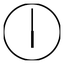

(64, 64)


In [5]:
from PIL import Image
from IPython.display import display

# Display the first image to verify
sample_image_path = os.path.join(IMG_DIR, "clock_06_00.png")
image = Image.open(sample_image_path)
display(image)
print(image.size)

# Autoencoder

In [6]:
import sys
print(sys.path)
import site
print(site.getsitepackages())

['', '/opt/software-current/2023.06/x86_64/amd/zen4/software/Python-bundle-PyPI/2023.06-GCCcore-12.3.0/lib/python3.11/site-packages', '/opt/software-current/2023.06/x86_64/amd/zen4/software/virtualenv/20.23.1-GCCcore-12.3.0/lib/python3.11/site-packages', '/opt/software-current/2023.06/x86_64/amd/zen4/software/cryptography/41.0.1-GCCcore-12.3.0/lib/python3.11/site-packages', '/opt/software-current/2023.06/x86_64/amd/zen4/software/cffi/1.15.1-GCCcore-12.3.0/lib/python3.11/site-packages', '/opt/software-current/2023.06/x86_64/amd/zen4/software/Python/3.11.3-GCCcore-12.3.0/easybuild/python', '/opt/software-current/2023.06/x86_64/amd/zen4/software/Python/3.11.3-GCCcore-12.3.0/lib/python311.zip', '/opt/software-current/2023.06/x86_64/amd/zen4/software/Python/3.11.3-GCCcore-12.3.0/lib/python3.11', '/opt/software-current/2023.06/x86_64/amd/zen4/software/Python/3.11.3-GCCcore-12.3.0/lib/python3.11/lib-dynload', '/mnt/home/moham147/experiments/manifold-learning/.venv/lib/python3.11/site-packages

In [7]:
import torch
import torch.nn as nn

# Autoencoder for 1xnxn images
class DeepAutoencoder(nn.Module):
  def __init__(self, input_dim, n_hidden):
    super(DeepAutoencoder, self).__init__()
    
    # Encoder: Convolutional layers for feature extraction
    self.encoder_conv = nn.Sequential(
      nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),
      nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),
      nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),
    )

    self.encoder_fc = nn.Sequential(
        nn.Linear(512 * 256, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, n_hidden)  # Predicting hour and minute
    )

    # Decoder: Fully connected layers for reconstruction
    self.decoder_fc = nn.Sequential(
        nn.Linear(n_hidden, 128),
        nn.ReLU(),
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.Linear(256, 512 * 256)
    )

    # Decoder: Convolutional layers for image reconstruction
    self.decoder_conv = nn.Sequential(
      nn.ConvTranspose2d(512, 256, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1)
    )

  def forward(self, x):
    x = self.encoder_conv(x)
    x = torch.flatten(x, start_dim=1)  # Flatten the output
    latent = self.encoder_fc(x)  # Encode to latent space

    x = self.decoder_fc(latent)  # Decode from latent space
    x = x.view(-1, 512, 16, 16)  # Reshape to match decoder input
    x = self.decoder_conv(x)  # Decode to image space
    reconstructed = torch.sigmoid(x)  # Apply sigmoid to ensure pixel values are between 0 and 1
    return reconstructed, latent



# Regressors

In [8]:
# Model 1: Predict (hour, minute) as 2D labels
class ClockRegressor(nn.Module):
    def __init__(self, out_dim=2):
        super(ClockRegressor, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(512 * 256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, out_dim)  # Predicting hour and minute
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        x = torch.sigmoid(x) # Ensure output is between 0 and 1
        return x



# Datasets

In [9]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# Custom dataset class
class ClockDataset(Dataset):
    def __init__(self, img_dir, transform=None, supervised=True):
        self.img_dir = img_dir
        self.transform = transform
        self.supervised = supervised
        self.images = os.listdir(img_dir)
        self.labels_df = pd.read_csv("data/clock_labels.csv")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        if self.supervised:
            label_2d, label_1d = self.get_label(img_name)
            return image, label_2d, label_1d
        return image
    

    def get_label(self, img_name):
      row = self.labels_df[self.labels_df["filename"] == img_name].iloc[0]

      return (
          torch.tensor([row["hour"], row["minute"]], dtype=torch.float32),  # 2D label
          torch.tensor(row["time_in_minutes"], dtype=torch.float32)  # 1D label
      )



# Define data transformations
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

BATCH_SIZE = 32

# Load supervised dataset
train_dataset = ClockDataset(img_dir=IMG_DIR, transform=transform, supervised=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Load unsupervised dataset for autoencoder
unsupervised_dataset = ClockDataset(img_dir=IMG_DIR, transform=transform, supervised=False)
unsupervised_loader = DataLoader(unsupervised_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
for batch, labels_2d, labels_1d in train_loader:
    print(f"Batch of images shape: {batch.shape}")
    print(f"Batch of 2D labels shape: {labels_2d.shape}")
    print(f"Batch of 1D labels shape: {labels_1d.shape}")
    break

Batch of images shape: torch.Size([32, 1, 64, 64])
Batch of 2D labels shape: torch.Size([32, 2])
Batch of 1D labels shape: torch.Size([32])


# Train Autoencoder

In [3]:
ae = DeepAutoencoder(n_hidden=2)

# count number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of parameters in autoencoder: {count_parameters(ae)}")

Number of parameters in autoencoder: 70442243


In [11]:

HIDDEN_UNITS = 2
LEARNING_RATE = 0.0002

ae = DeepAutoencoder(n_hidden=HIDDEN_UNITS)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(ae.parameters(), lr=LEARNING_RATE)

# Training loop for autoencoder
num_epochs = 3
for epoch in range(num_epochs):
    for batch in unsupervised_loader:
        # Forward pass
        reconstructed, _ = ae(batch) # Get reconstructed image, ignore latent
        loss = criterion(reconstructed, batch)
        print(loss.item())
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x32768 and 131072x256)

# Train regressors

In [10]:

LEARNING_RATE = 0.0002

regressor = ClockRegressor(out_dim=2)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(regressor.parameters(), lr=LEARNING_RATE)

# Training loop for regressor
num_epochs = 3
for epoch in range(num_epochs):
    for batch, labels_2d, labels_1d in train_loader:
        # Forward pass
        outputs = regressor(batch)
        loss = criterion(outputs, labels_2d)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    

0.09335006773471832
0.08971729129552841
0.07255273312330246
0.10962341725826263
0.07685185968875885
0.07334550470113754
0.08128383755683899
0.0822688490152359
0.08242283761501312


KeyboardInterrupt: 